In [1]:
import matplotlib.pyplot as plt 
import csv 
import pandas as pd 
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
import seaborn as sns

Read CSV data into panda DataFrame "distance_barrier", print first five rows and plot the data in a scatterplot:

   chi-1_fa   S-2_fa  distance  barrier
0   564.775  72.0370    0.9348     14.8
1   482.135  57.4704    0.9699     12.4
2   670.614  89.7068    0.9983      5.2
3   354.089  49.8734    0.9353     10.5
4   472.145  60.6480    0.9310      9.4


<Axes: xlabel='distance', ylabel='barrier'>

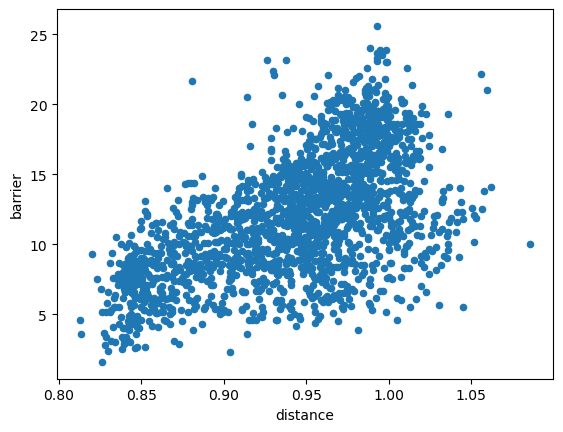

In [2]:
distance_barrier = pd.read_csv("data/vaskas_features_properties_smiles_filenames.csv", usecols=[1, 26, 90, 91])
print(distance_barrier.head())
distance_barrier.plot(kind='scatter', x='distance', y='barrier')


#plt.show()

<Axes: xlabel='chi-1_fa', ylabel='barrier'>

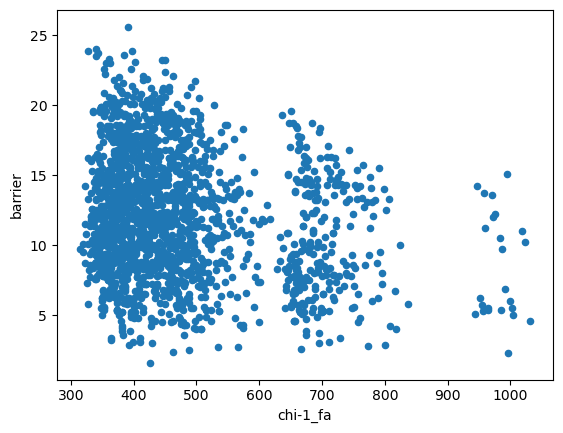

In [3]:
distance_barrier.plot(kind='scatter', x='chi-1_fa', y='barrier')


<Axes: xlabel='S-2_fa', ylabel='barrier'>

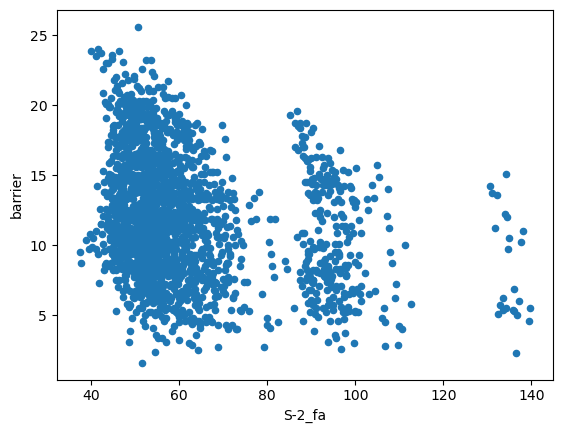

In [4]:
distance_barrier.plot(kind='scatter', x='S-2_fa', y='barrier')

In [5]:
distance_barrier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   chi-1_fa  1947 non-null   float64
 1   S-2_fa    1947 non-null   float64
 2   distance  1947 non-null   float64
 3   barrier   1947 non-null   float64
dtypes: float64(4)
memory usage: 61.0 KB


Potential normalization of entire Data Frame before fitting Isolation Forest model:

In [6]:
print(distance_barrier.head())
min_max_scaler = preprocessing.MinMaxScaler()
distance_barrier_scaled = min_max_scaler.fit_transform(distance_barrier)
scaled = pd.DataFrame(distance_barrier_scaled, columns = distance_barrier.columns)
print(scaled.head())

   chi-1_fa   S-2_fa  distance  barrier
0   564.775  72.0370    0.9348     14.8
1   482.135  57.4704    0.9699     12.4
2   670.614  89.7068    0.9983      5.2
3   354.089  49.8734    0.9353     10.5
4   472.145  60.6480    0.9310      9.4
   chi-1_fa    S-2_fa  distance   barrier
0  0.349373  0.338506  0.446964  0.550000
1  0.234254  0.196349  0.575347  0.450000
2  0.496808  0.510948  0.679225  0.150000
3  0.055885  0.122209  0.448793  0.370833
4  0.220338  0.227360  0.433065  0.325000


Define variables for the isolation forest model and fit it to the data. Set contamination percentage = percentage of outliers. Define anomaly scores (continuous variable) and anomaly score (descrete variable [1, -1]). 

In [7]:

anomaly_inputs = ['distance', 'barrier', 'S-2_fa', 'chi-1_fa']
model_IF = IsolationForest(contamination=0.02, random_state=42)
model_IF.fit(scaled[anomaly_inputs])
scaled['anomaly_scores'] = model_IF.decision_function(scaled[anomaly_inputs])
scaled['anomaly'] = model_IF.predict(scaled[anomaly_inputs])

In [8]:
scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   chi-1_fa        1947 non-null   float64
 1   S-2_fa          1947 non-null   float64
 2   distance        1947 non-null   float64
 3   barrier         1947 non-null   float64
 4   anomaly_scores  1947 non-null   float64
 5   anomaly         1947 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 83.8 KB


In [9]:
scaled.loc[:, ['distance', 'barrier', 'chi-1_fa', 'S-2_fa', 'anomaly_scores', 'anomaly'] ]

,distance,barrier,chi-1_fa,S-2_fa,anomaly_scores,anomaly
0,0.446964,0.550000,0.349373,0.338506,0.125257,1
1,0.575347,0.450000,0.234254,0.196349,0.212703,1
2,0.679225,0.150000,0.496808,0.510948,0.054451,1
3,0.448793,0.370833,0.055885,0.122209,0.203709,1
4,0.433065,0.325000,0.220338,0.227360,0.214488,1
...,...,...,...,...,...,...
1942,0.478786,0.554167,0.236717,0.253411,0.195869,1
1943,0.567301,0.504167,0.109578,0.169157,0.224298,1
1944,0.460132,0.583333,0.505262,0.511336,0.092060,1
1945,0.566203,0.479167,0.591225,0.563670,0.104139,1


Define a function with Seaborn to plot outliers and inliers in scatterplots, where the anomaly_score is color coded. 

In [10]:
def outlier_plot(data, outlier_method_name, x_var, y_var, h_var, s_var, xaxis_limits=[0,1], yaxis_limits=[0,1]):
    
    print(f'Outlier Method: {outlier_method_name} (normalized: distance vs barrier vs chi-1_fa vs S-2_fa)')

    method = f'{outlier_method_name}_anomaly'

    print(f"Number of anomalous values {len(data[data['anomaly']==-1])}")
    print(f"Number of non anomalous values {len(data[data['anomaly']==1])}")
    print(f"Total number of values: {len(data)}")

    g = sns.relplot(data=data, x=x_var, y=y_var, col='anomaly', hue=h_var, size=s_var) 
    g.fig.suptitle(f'Outlier method: {outlier_method_name} (normalized: distance vs barrier vs chi-1_fa vs S-2_fa)', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n{len(data[data['anomaly']== 1])} points")
    return g
    
    

Outlier Method: Isolation Forest (normalized: distance vs barrier vs chi-1_fa vs S-2_fa)
Number of anomalous values 39
Number of non anomalous values 1908
Total number of values: 1947


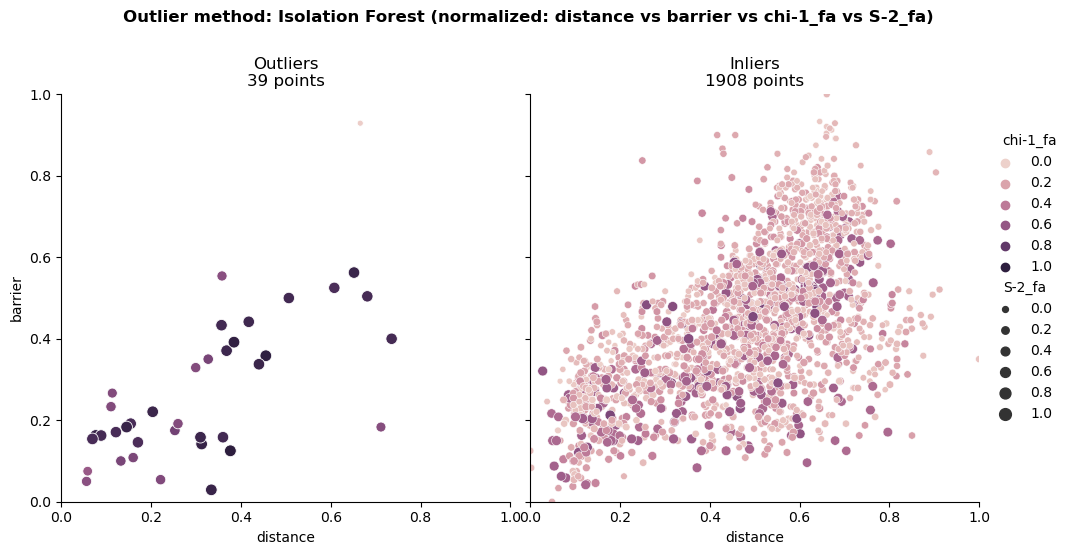

In [11]:
outlier_plot(scaled, "Isolation Forest", "distance", "barrier", "chi-1_fa", "S-2_fa", [0, 1], [0, 1])